In [1]:
%matplotlib inline

import os,json,glob,sys
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances

from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn import datasets
from nilearn import input_data
import nilearn
import nilearn.plotting
from nilearn import image
from nilearn.image import mean_img
from nilearn.image import threshold_img
from nilearn import plotting
from nilearn.regions import connected_regions
from nilearn.regions import RegionExtractor
from nilearn.image import concat_imgs, index_img
from nilearn.plotting import find_xyz_cut_coords

import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, spm   
from nipype.interfaces.base import Bunch
import nipype.interfaces.spm as spm

import nibabel


/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
data_dir = '/home/jovyan/ClassData/LabResults'
mask_dir = '/home/jovyan/ClassData/custom_modelling'

In [5]:
# load one participant's data
sub_list = ['sid000006', 'sid000118', 'sid000689', 'sid000747','sid001548',
            'sid001550','sid001551','sid001560','sid001561','sid001562']
sub_list.sort()
sub = sub_list[0]

In [6]:
sub_list

['sid000006',
 'sid000118',
 'sid000689',
 'sid000747',
 'sid001548',
 'sid001550',
 'sid001551',
 'sid001560',
 'sid001561',
 'sid001562']

In [7]:
file_list = glob.glob(os.path.join(data_dir, '*.nii.gz'))
f = glob.glob(os.path.join(data_dir, '*School vs. others.nii.gz'))
file_list = [item for item in file_list if item not in f]
file_list.sort()
conditions =  ['Career', 'Event', 'School', 'Social']

In [8]:
#!find /home/jovyan/ClassData/LabResults/ -type f -name "*.nii" -exec mv {} {}.gz \;

In [9]:
file_list

['/home/jovyan/ClassData/LabResults/sid000006_1_Career.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_1_Event.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_1_School.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_1_Social.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_2_Career.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_2_Event.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_2_School.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_2_Social.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_3_Career.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_3_Event.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_3_School.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000006_3_Social.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000118_1_Career.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000118_1_Event.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid000118_1_School.nii.gz',
 '/home/jovyan/ClassData/LabResults/sid00011

In [45]:
#list of coordinates here
coords=np.array([[24, -4, -20],[-22, -4, -20],
               [26, -14, -18],[-26, -18, -18],
               [2, 32, 22],
               [2, -44, 66],[-26, -62, 68]])

In [46]:
coords

array([[ 24,  -4, -20],
       [-22,  -4, -20],
       [ 26, -14, -18],
       [-26, -18, -18],
       [  2,  32,  22],
       [  2, -44,  66],
       [-26, -62,  68]])

In [47]:
#img=nilearn.image.load_img(glob.glob('/home/jovyan/ClassData/LabResults/*_1_Social.nii.gz'))


In [48]:
img = nilearn.image.load_img(file_list[0])

In [49]:
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=4, radius=5.,
    detrend=False, standardize=False)

In [50]:
values = spheres_masker.fit_transform(file_list[0])

In [51]:
values

array([[-0.32659897, -0.22785337, -0.3080268 , -0.00186784, -0.14229125,
        -0.43305948, -0.7533148 ]], dtype=float32)

In [52]:
values= np.empty((0, 7))
for file in file_list:
    temp = spheres_masker.fit_transform(file)
    values=np.append(values,temp,axis=0)

In [55]:
values.shape

(120, 7)

In [58]:
len(list_)

0

# Make dataframe

In [61]:
# dont run
list_ = []
for i in range(0,len(file_list)):
    tryy = file_list[i] 
    tryyy=os.path.splitext(os.path.split(tryy)[1])[0]
    tryyyy=os.path.splitext(os.path.split(tryyy)[1])[0]
    list_.append(tryyy)


In [56]:
list_ = []
sub = []
run = []
category = []
for i in range(0,len(file_list)):
    tryy = file_list[i] 
    tryyy=os.path.splitext(os.path.split(tryy)[1])[0]
    tryyyy=os.path.splitext(os.path.split(tryyy)[1])[0]
    s=tryyyy.split("_")[0]
    r=tryyyy.split("_")[1]
    c=tryyyy.split("_")[2]
    sub.append(s)
    run.append(r)
    category.append(c)


In [71]:
str=list_[1]
str.split("_")[2]

'Event.nii'

In [57]:
len(category)

120

In [65]:
dataset = pd.DataFrame({'Subject': sub,'Run': run, 'Category': category,
                        "Amygdala_Right": values[:, 0], "Amygdala_Left": values[:, 1],
                        "Hippocampus_Right": values[:, 2],"Hippocampus_Left": values[:, 3],
                        "CingulateCortex": values[:, 4],
                        "OccipitalParietal_Right": values[:, 5],"OccipitalParietal_Left": values[:, 6]
                       })

In [14]:
 dataset
#dataset = pd.read_csv('/home/jovyan/ClassData/LabResults/ROI_Results.csv')

,Unnamed: 0,Subject,Run,Category,Amygdala_Right,Amygdala_Left,Hippocampus_Right,Hippocampus_Left,CingulateCortex,OccipitalParietal_Right,OccipitalParietal_Left
0,0,sid000006,1,Career,-0.326599,-0.227853,-0.308027,-0.001868,-0.142291,-0.433059,-0.753315
1,1,sid000006,1,Event,-0.611559,-0.752813,-0.431570,-0.412553,-0.014250,-0.824741,-0.427617
2,2,sid000006,1,School,-0.251163,-0.162192,-0.179967,-0.187662,0.183228,-0.577435,-0.218058
3,3,sid000006,1,Social,-0.353722,-0.077538,-0.332599,-0.122749,0.089219,-0.903357,-0.265942
4,4,sid000006,2,Career,-0.483564,-0.638484,-0.365118,-0.689190,-1.135421,-0.380421,-0.043044
...,...,...,...,...,...,...,...,...,...,...,...
115,115,sid001562,2,Social,0.411590,0.250521,0.449049,0.275039,-0.072193,-0.537684,-0.005420
116,116,sid001562,3,Career,-0.269863,-0.470763,-0.512180,-0.314969,-0.341367,1.189146,-0.278457
117,117,sid001562,3,Event,0.667835,0.143194,1.109405,0.900281,0.041505,0.630876,0.360198
118,118,sid001562,3,School,-0.295949,0.144104,-0.246401,0.124466,-0.304313,-0.715601,-0.287037


In [67]:
dataset.to_csv('/home/jovyan/ClassData/LabResults/ROI_Results.csv')

# Run RSA using values mean values from all regions

In [35]:
#career=dataset[dataset.Filename == '*Careernii.gz'].mean
#school=dataset[dataset.Filename == '*School'].mean
#social=dataset[dataset.Filename == '*Social'].mean
#event=dataset[dataset.Filename == '*Event'].mean
#allcategories=[career,social,event,school]
#1-allcategories.corr

## Creating function

In [74]:
# was trying to create function here for each region so that we don't have to repeat the steps again
def rsa_plot(region):
    career = dataset[dataset.Category == 'Career'].region.mean()
    school = dataset[dataset.Category == 'School'].region.mean()
    social = dataset[dataset.Category == 'Social'].region.mean()
    event = dataset[dataset.Category == 'Event'].region.mean()
    list_ = [career,school,social,event]
    
    full = []
    
    for idx,x in enumerate(list_):
        full.append([abs(x-y) for y in list_])
    mat = np.array(full)
    
    x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis  
    y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis
    sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)


In [1]:
#reg = Amygdala_Right'
#rsa_plot(reg)

## For Amygdala

### Right

In [15]:
career = dataset[dataset.Category == 'Career'].Amygdala_Right.mean()
school = dataset[dataset.Category == 'School'].Amygdala_Right.mean()
social = dataset[dataset.Category == 'Social'].Amygdala_Right.mean()
event = dataset[dataset.Category == 'Event'].Amygdala_Right.mean()

#allcategories=[career,social,event,school]
#1-allcategories.corr

In [16]:
list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

In [17]:
mat

array([[0.        , 0.11387002, 0.14891876, 0.07479347],
       [0.11387002, 0.        , 0.03504874, 0.03907655],
       [0.14891876, 0.03504874, 0.        , 0.0741253 ],
       [0.07479347, 0.03907655, 0.0741253 , 0.        ]])

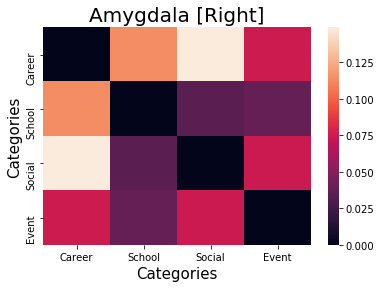

In [19]:
x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Amygdala [Right]", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

In [ ]:
#1-dataset[dataset.Filename == '*Career'].corr

### Left

In [20]:
career = dataset[dataset.Category == 'Career'].Amygdala_Left.mean()
school = dataset[dataset.Category == 'School'].Amygdala_Left.mean()
social = dataset[dataset.Category == 'Social'].Amygdala_Left.mean()
event = dataset[dataset.Category == 'Event'].Amygdala_Left.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

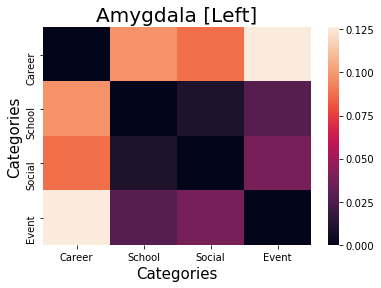

In [22]:
x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Amygdala [Left]", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

## For Hippocampus

### Right 

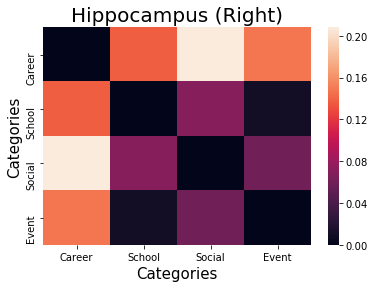

In [26]:
career = dataset[dataset.Category == 'Career'].Hippocampus_Right.mean()
school = dataset[dataset.Category == 'School'].Hippocampus_Right.mean()
social = dataset[dataset.Category == 'Social'].Hippocampus_Right.mean()
event = dataset[dataset.Category == 'Event'].Hippocampus_Right.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

x_axis_labels = ['Career','School','Social', 'Event'] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Hippocampus (Right)", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

### Left

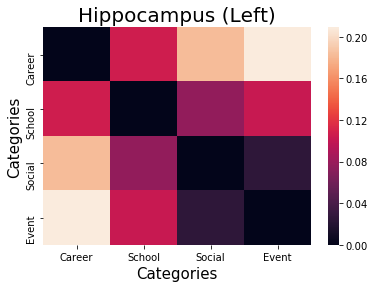

In [25]:
career = dataset[dataset.Category == 'Career'].Hippocampus_Left.mean()
school = dataset[dataset.Category == 'School'].Hippocampus_Left.mean()
social = dataset[dataset.Category == 'Social'].Hippocampus_Left.mean()
event = dataset[dataset.Category == 'Event'].Hippocampus_Left.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Hippocampus (Left)", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

## For Cingulate Cortex

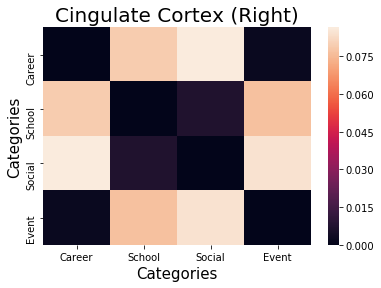

In [28]:
career = dataset[dataset.Category == 'Career'].CingulateCortex.mean()
school = dataset[dataset.Category == 'School'].CingulateCortex.mean()
social = dataset[dataset.Category == 'Social'].CingulateCortex.mean()
event = dataset[dataset.Category == 'Event'].CingulateCortex.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Cingulate Cortex (Right)", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

## For Occipital Parietal

### Right 

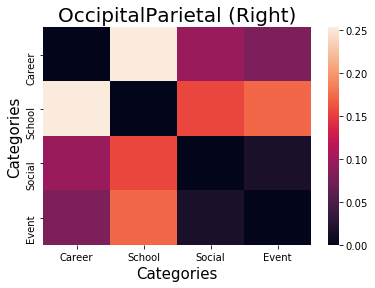

In [30]:
career = dataset[dataset.Category == 'Career'].OccipitalParietal_Right.mean()
school = dataset[dataset.Category == 'School'].OccipitalParietal_Right.mean()
social = dataset[dataset.Category == 'Social'].OccipitalParietal_Right.mean()
event = dataset[dataset.Category == 'Event'].OccipitalParietal_Right.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("OccipitalParietal (Right)", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()

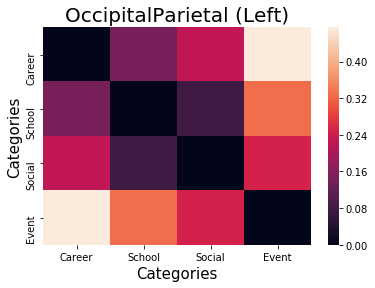

In [31]:
career = dataset[dataset.Category == 'Career'].OccipitalParietal_Left.mean()
school = dataset[dataset.Category == 'School'].OccipitalParietal_Left.mean()
social = dataset[dataset.Category == 'Social'].OccipitalParietal_Left.mean()
event = dataset[dataset.Category == 'Event'].OccipitalParietal_Left.mean()

list_ = [career,school,social,event]

full = []
for idx,x in enumerate(list_):
    full.append([abs(x-y) for y in list_])
    
mat = np.array(full)

x_axis_labels = ['Career','School','Social', 'Event' ] # labels for x-axis
y_axis_labels = ['Career','School','Social', 'Event'] # labels for y-axis

sns.heatmap(mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("OccipitalParietal (Left)", fontsize = 20) # title with fontsize 20
plt.xlabel('Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Categories', fontsize = 15) # y-axis label with fontsize 15
plt.show()